<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/image_classification/homer_bart_classification_with_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homer/Bart image classification with feature extraction

### Importing the libraries

In [1]:
import cv2
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.15.0'

In [2]:
%run '/content/drive/MyDrive/Workspace/Computer Vision/cv_common.ipynb'

Common library was successfully loaded


### Loading dataset

In [3]:
zip_file_path = f'{datasets_directory}/Simpsons/simpsons.zip'
working_directory = './content/simpsons'
data_extract_path = f'{working_directory}/datasets'
train_set_path = f'{data_extract_path}/simpsons/training_set'
test_set_path = f'{data_extract_path}/simpsons/test_set'

In [4]:
create_empty_directory(data_extract_path)
zipe_file = zipfile.ZipFile(file=zip_file_path, mode = 'r')
zipe_file.extractall(data_extract_path)
zipe_file.close()

./content/simpsons/datasets directory already exists


### Extracting features

In [61]:
class FeatureGroup:
  def __init__(self, name, extraction_colors):
    self.name = name
    self.extraction_colors = extraction_colors

class FeatureDefinition:
  def __init__(self, name, group, pixel_range):
    self.name = name
    self.group = group
    self.pixel_range = pixel_range

class HomerFeatures:
  mouth = 'h_mouth'
  pants = 'h_pants'
  shoes = 'h_shoes'

class BartFeatures:
  tshirt = 'b_tshirt'
  shorts = 'b_shorts'
  sneakers = 'b_sneakers'

class FeaturePixelCounters:
  def __init__(self, features_definition, height, width):
    self.pixel_counts = {}
    self.height = height
    self.width = width

    for definition in features_definition:
      self.pixel_counts[definition.name] = 0

  def increment(self, feature_name):
    if not (feature_name in self.pixel_counts):
      raise Exception(f'Counter for the {feature_name} featuer was not found')

    self.pixel_counts[feature_name] += 1

  def calculate_statistics(self):
    statistics = {}

    for feature_name in self.pixel_counts:
      pixel_count = self.pixel_counts[feature_name]
      statistics[feature_name] = round((pixel_count / (self.height * self.width)) * 100, 9)

    return statistics

class Channel:
  def __init__(self, id, name):
    self.name = name
    self.id = id

class Channels:
  blue = Channel(0, 'blue')
  green = Channel(1, 'green')
  red = Channel(2, 'red')

class Pixel:
  def __init__(self, blue, green, red):
    self.blue = blue
    self.green = green
    self.red = red

  def from_image(image, height, width):
    blue = image.item(height, width, Channels.blue.id)
    green = image.item(height, width, Channels.green.id)
    red = image.item(height, width, Channels.red.id)

    return Pixel(blue, green, red)

class PixelRange:
  def __init__(self, from_pixel, to_pixel):
    self.from_pixel = from_pixel
    self.to_pixel = to_pixel

  def contains(self, pixel):
    blue = pixel.blue
    green = pixel.green
    red = pixel.red

    if (blue >= self.from_pixel.blue \
        and blue <= self.to_pixel.blue \
        and green >= self.from_pixel.green \
        and green <= self.to_pixel.green \
        and red >= self.from_pixel.red \
        and red <= self.to_pixel.red):
      return True
    else:
      return False

  def from_tuples(from_tuple, to_tuple):
    blue = from_tuple[Channels.blue.id]
    green = from_tuple[Channels.green.id]
    red = from_tuple[Channels.red.id]

    from_pixel = Pixel(blue, green, red)

    blue = to_tuple[Channels.blue.id]
    green = to_tuple[Channels.green.id]
    red = to_tuple[Channels.red.id]

    to_pixel = Pixel(blue, green, red)

    return PixelRange(from_pixel, to_pixel)

class ImageFeatueExtractor:

  def __init__(self, max_to_preview):
    self.max_to_preview = max_to_preview

  def extract_from_directory(self, directory, df, preview=False):
    previewed_image_count = 1

    files = [os.path.join(directory, f) for f in sorted(os.listdir(directory))]
    for image_path in files:
      try:
        original_image = cv2.imread(image_path)
        (image_height, image_width) = original_image.shape[:2]
      except:
        continue

      image = original_image.copy()
      image_features = []

      image_name = os.path.basename(os.path.normpath(image_path))

      if image_name.startswith('b'):
        class_name = 0
      else:
        class_name = 1

      pixel_counters = FeaturePixelCounters(features_definition, image_height, image_width)
      for height in range(0, image_height):
        for width in range(0, image_width):
          pixel = Pixel.from_image(image, height, width)

          for feature_definition in features_definition:
            pixel_range = feature_definition.pixel_range

            if pixel_range.contains(pixel):
                image[height, width] = feature_definition.group.extraction_colors
                pixel_counters.increment(feature_definition.name)


      statistics = pixel_counters.calculate_statistics()
      image_features = list(statistics.values())
      image_features.append(class_name)

      df.loc[len(df.index)] = image_features

      if preview == True and previewed_image_count <= self.max_to_preview:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        fig, im = plt.subplots(1, 2)
        im[0].axis('off')
        im[0].imshow(original_image)
        im[1].axis('off')
        im[1].imshow(image)
        plt.show()
        previewed_image_count += 1


In [35]:
features_definition = []

homer_group = FeatureGroup('homer', [0, 255, 255])
bart_group = FeatureGroup('bart', [0, 255, 128])

pixel_range = PixelRange.from_tuples((95, 160, 175), (140, 185, 200))
definition = FeatureDefinition(HomerFeatures.mouth, homer_group, pixel_range)
features_definition.append(definition)

pixel_range = PixelRange.from_tuples((150, 98, 0), (180, 120, 90))
definition = FeatureDefinition(HomerFeatures.pants, homer_group, pixel_range)
features_definition.append(definition)

pixel_range = PixelRange.from_tuples((25, 25, 25), (45, 45, 45))
definition = FeatureDefinition(HomerFeatures.shoes, homer_group, pixel_range)
features_definition.append(definition)

pixel_range = PixelRange.from_tuples((11, 85, 240), (22, 105, 255))
definition = FeatureDefinition(BartFeatures.tshirt, bart_group, pixel_range)
features_definition.append(definition)

pixel_range = PixelRange.from_tuples((125, 0, 0), (170, 12, 20))
definition = FeatureDefinition(BartFeatures.shorts, bart_group, pixel_range)
features_definition.append(definition)

pixel_range = PixelRange.from_tuples((125, 0, 0), (170, 12, 20))
definition = FeatureDefinition(BartFeatures.sneakers, bart_group, pixel_range)
features_definition.append(definition)


In [63]:
feature_extractor = ImageFeatueExtractor(3)
columns = [HomerFeatures.mouth, HomerFeatures.pants, HomerFeatures.shoes, BartFeatures.tshirt, BartFeatures.shorts, BartFeatures.sneakers, 'class']
train_df = pd.DataFrame(columns=columns)

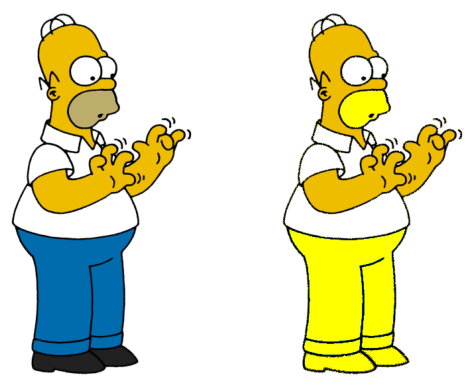

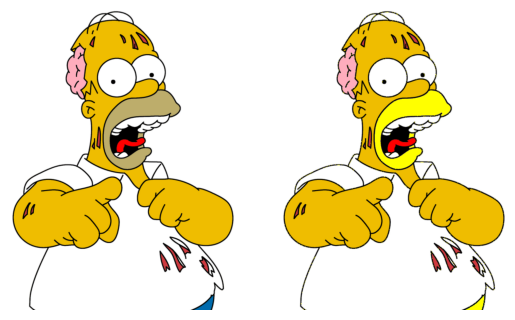

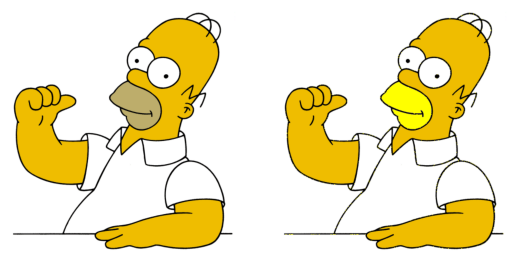

In [64]:
directory = f'{train_set_path}/homer'
feature_extractor.extract_from_directory(directory, train_df, preview=True)

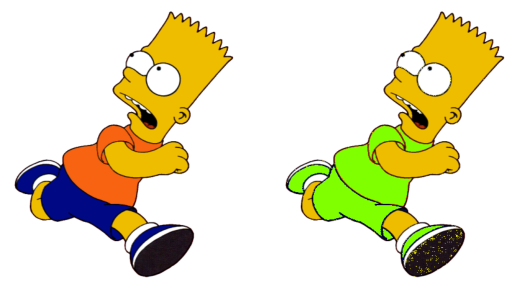

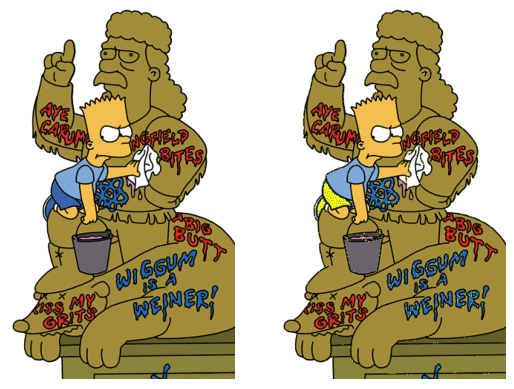

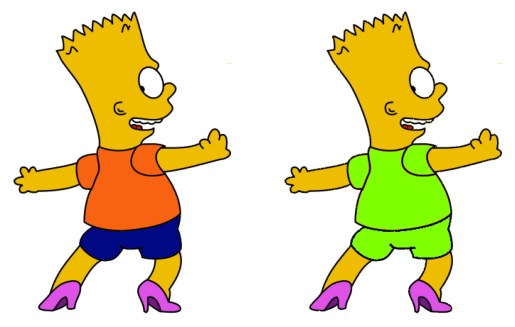

In [66]:
directory = f'{train_set_path}/bart'
feature_extractor.extract_from_directory(directory, train_df, preview=True)

In [67]:
len(train_df)

196